***Note: this notebook was runned on google colab***

# **DATAFEST AFRICA DATATHON 2023 CHALLENGE**

*DS Challenge: Fraud Detection for online payment platform*

**Description**: The Fraud Detection  is a crucial asset for our business, providing valuable insights and opportunities for enhancing the security and trustworthiness of our online payment platform. This dataset represents transactions and user-related data collected over time from our platform. The primary goal is to develop an advanced predictive model to identify potentially fraudulent transactions.

**Context**
Our online payment platform processes millions of transactions daily, making it vulnerable to various types of fraudulent activities. These activities pose a significant threat to both our business and our customers. To safeguard our platform and enhance user experience, we aim to leverage the power of data science and machine learning to proactively detect and prevent fraudulent transactions.

**Objectives**
- Fraud Detection Model: You are required to build an advanced machine learning model to predict whether a given transaction is potentially fraudulent or not. This model will be vital for real-time decision-making, allowing us to flag and investigate suspicious activities promptly.

- Enhanced Security: The primary aim is to enhance the security of our platform. By identifying fraudulent transactions early, we can take preventive measures to protect our customers and our business from financial losses.

- User Trust: Fraud detection directly impacts the trust our customers have in our platform. Accurate and efficient detection of fraudulent activities assures our users that their transactions are safe and secure.

- Operational Efficiency: Implementing automated fraud detection reduces the manual effort required for monitoring transactions, allowing our business to operate more efficiently.

Business Impact
The success of this project has significant implications for our business. An effective fraud detection system will help us maintain the integrity of our platform, foster user trust, and ensure the sustainability of our operations. By reducing fraud-related losses and improving the overall user experience, we aim to achieve long-term growth and success in the competitive online payment industry.


# **TEAM X (MEMBERS)**

EBIENDELE EMMANUEL OSEWE

HONOUR JESUS BEZALEEL

OLAMILEKAN OMOTOSHO

# **Installing/Importing Library Packages**

In [1]:
!pip install catboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.1 MB/s eta 0:00:00


# **IMPORT LIBRARY PACKAGES**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# **UTILS**

In [3]:
#Plot the Features Importances
def plotImp(model, X , num = 30, fig_size = (60, 30)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('cb_importances-01.png')
    plt.show()
    return feature_imp.sort_values(by="Value",ascending=False)

#Plot the Features Importances
def plotImp(model, X , num = 30, fig_size = (60, 30)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('cb_importances-01.png')
    plt.show()
    return feature_imp.sort_values(by="Value",ascending=False)




#Reduce Memory Usage
def reduce_memory_usage(df):

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')

    return df

# **CONNECTING GOOGLE DRIVE INTO GOOGLE COLAB**

In [4]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="150" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive!
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


# **DATA LOADING**

In [5]:
# load the data
path = '/content/drive/MyDrive/DatafestAfrica2023'

**DATA PROCESSING**

**Step 1: Viewing the dataset**

In [6]:
data = pd.read_csv('/content/drive/MyDrive/DatafestAfrica2023 /FraudDetectionDataset.csv')
data.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag
0,51595306,9822,163.080,2023-01-02 07:47:54,4044,ACH Transfer,KOR,Charity,GPS Device,42.23.223.120,Links,Tizen,Industrial & Scientific,68,Doctor,66826.210,Prefer Not to Say,Pro,In Transit,9.340,24.220,Daytime,26,2.710,United Kingdom,NOK,Consultation Fee,343,cox.co.uk,3,Bluetooth Authentication,0
1,85052974,4698,430.740,2021-09-12 15:15:41,4576,2Checkout,VNM,Cashback,Medical Device,39.52.212.120,Beaker,Windows Server,Beauty & Cosmetics,22,Chemist,89356.710,Genderqueer,Pending Approval,Resolved,65.280,55.110,Daytime,60,3.950,Mexico,EGP,Cashback Reward,688,gmail.com,13,NFC Tag,1
2,23954324,8666,415.740,2023-01-12 17:25:58,4629,Google Wallet,MEX,Reward,Vehicle Infotainment System,243.180.236.29,Opera,Android,Real Estate,71,Nurse,58438.630,Male,Pro,Posted,44.050,53.840,Daytime,81,3.810,Qatar,MXN,Acquisition,371,rocketmail.com,7,Token,1
3,44108303,9012,565.890,2021-02-27 11:31:00,3322,Check,SGP,Purchase,Kiosk,212.186.227.14,Konqueror,CentOS,Appliances,78,Nurse,3426.920,Agender,Premium,Closed,21.700,21.620,Daytime,18,2.670,Spain,CLP,Loan Repayment,687,roadrunner.co.uk,15,Time-Based OTP,1
4,66622683,5185,955.490,2022-09-24 04:06:38,7609,Worldpay,HKG,Acquisition,Smart Mirror,166.113.10.199,Basilisk,Ubuntu,Jewelry,31,Physicist,53080.120,Male,Free,Refunded,56.630,53.710,Daytime,98,3.190,Israel,RUB,Dividend Reinvestment,605,protonmail.co.uk,17,Password,1


**Step 2: review the shape of the dataset i.e determine the rows and columns**

In [7]:
data.shape #6,000 columns, 32 rows

(6000000, 32)

**Step 3: Descriptive Statistics**

In [8]:
data.describe() #determine the mean, standard deviation, minimum, maximum of our dataset using the function shape

,Transaction ID,User ID,Transaction Amount,Merchant ID,User Age,User Income,Location Distance,Time Taken for Transaction,User's Transaction History,Merchant's Reputation Score,User's Credit Score,Merchant's Business Age,Fraudulent Flag
count,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000
mean,55019059.604,5499.571,500.552,5500.817,49.002,50493.280,50.506,30.495,50.484,2.999,574.953,10.497,0.500
std,25980671.714,2598.744,288.417,2598.350,18.185,28582.234,28.576,17.036,28.867,1.154,159.020,5.765,0.500
min,10000041.000,1000.000,1.000,1000.000,18.000,1000.020,1.000,1.000,1.000,1.000,300.000,1.000,0.000
25%,32516659.750,3248.000,250.790,3251.000,33.000,25734.458,25.760,15.740,25.000,2.000,437.000,5.000,0.000
50%,55029874.000,5499.000,500.510,5501.000,49.000,50502.940,50.510,30.500,50.000,3.000,575.000,10.000,0.000
75%,77524866.250,7751.000,750.440,7752.000,65.000,75234.535,75.250,45.260,75.000,4.000,713.000,15.000,1.000
max,99999883.000,9999.000,1000.000,9999.000,80.000,100000.000,100.000,60.000,100.000,5.000,850.000,20.000,1.000


**Step 4: Data information**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 32 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Transaction ID                     int64  
 1   User ID                            int64  
 2   Transaction Amount                 float64
 3   Transaction Date and Time          object 
 4   Merchant ID                        int64  
 5   Payment Method                     object 
 6   Country Code                       object 
 7   Transaction Type                   object 
 8   Device Type                        object 
 9   IP Address                         object 
 10  Browser Type                       object 
 11  Operating System                   object 
 12  Merchant Category                  object 
 13  User Age                           int64  
 14  User Occupation                    object 
 15  User Income                        float64
 16  User Gender       

**CHECKING FOR MISSING VALUES**

In [11]:
data.isnull().sum()

Transaction ID                       0
User ID                              0
Transaction Amount                   0
Transaction Date and Time            0
Merchant ID                          0
Payment Method                       0
Country Code                         0
Transaction Type                     0
Device Type                          0
IP Address                           0
Browser Type                         0
Operating System                     0
Merchant Category                    0
User Age                             0
User Occupation                      0
User Income                          0
User Gender                          0
User Account Status                  0
Transaction Status                   0
Location Distance                    0
Time Taken for Transaction           0
Transaction Time of Day              0
User's Transaction History           0
Merchant's Reputation Score          0
User's Device Location               0
Transaction Currency     

**RENAMING OUR DATA COLUMNS FOR FEATURES SELECTION**

In [12]:
data.rename(columns = {'Transaction Type':'TransactionType'}, inplace = True)

In [13]:
data.rename(columns = {'Transaction Time of Day':'TransactionTimeofDay'}, inplace = True)

In [14]:
data.rename(columns = {"User's Email Domain":"UserEmailDomain"}, inplace = True)

In [15]:
data.rename(columns = {'Transaction Currency':'TransactionCurrency'}, inplace = True)

In [16]:
data.rename(columns = {'User Account Status':'UserAccountStatus'}, inplace = True)

In [17]:
data.rename(columns = {'Country Code':'CountryCode'}, inplace = True)

In [18]:
data.rename(columns = {'Merchant Category':'MerchantCategory'}, inplace = True)

In [19]:
data.rename(columns = {'User Gender':'UserGender'}, inplace = True)

In [20]:
data.rename(columns = {'User Occupation':'UserOccupation'}, inplace = True)

In [21]:
data.rename(columns = {'Payment Method':'PaymentMethod'}, inplace = True)

In [22]:
data.rename(columns = {'Device Type':'DeviceType'}, inplace = True)

In [23]:
data.rename(columns = {'Browser Type':'BrowserType'}, inplace = True)

In [24]:
data.rename(columns = {'Operating System':'OperatingSystem'}, inplace = True)

In [25]:
data.rename(columns = {'IP Address':'IPAddress'}, inplace = True)

In [26]:
data.rename(columns = {'Transaction Status':'TransactionStatus'}, inplace = True)

In [27]:
data.rename(columns = {'Transaction Authentication Method':'TransactionAuthenticationMethod'}, inplace = True)

# **EXPLORING OUR DISTRIBUTION DATASET**

1) Transaction Type

2) Payment Method

3) Device Type

In [28]:
# Exploring transaction type

print(data.TransactionType.value_counts())

Refund              300214
Donation            299814
Scholarship         150891
Purchase            150791
Withdrawal          150640
Buyback             150595
Dividend            150549
Service Charge      150500
Deposit             150464
Acquisition         150357
Investment          150244
Cashback            150237
Settlement          150182
Expense             150109
Bonus               150106
Auction             150105
Loan                150094
Reward              150091
Rental              149998
Fine                149995
Tax                 149994
Subscription        149938
Compensation        149912
Recharge            149896
Registration Fee    149884
Gift                149856
Reimbursement       149853
Payout              149767
Rent                149752
Royalty             149738
Interest            149696
Admission           149628
Invoice             149477
Membership          149460
Contribution        149423
Charity             149373
Transfer            149230
P

In [29]:
type = data["TransactionType"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(data, values=quantity, names=transactions, hole = 0.5, title="Distribution of Transaction Type")
figure.show()

In [30]:
# Exploring transaction type

print(data.PaymentMethod.value_counts())

Amazon Pay               150781
Cryptocurrency Wallet    150646
Afterpay                 150570
E-check                  150521
Masterpass               150467
Debit Card               150370
Alipay                   150366
Mobile Wallet            150349
Ethereum                 150332
Visa Checkout            150297
Diners Club              150291
Stripe                   150159
Apple Pay                150143
2Checkout                150115
Contactless Payment      150088
Bank Transfer            150088
Check                    150086
Bitcoin                  150076
Credit Card              150043
NFC Payment              150033
American Express         149964
Square Cash              149935
Money Order              149914
Google Wallet            149905
Wire Transfer            149888
WeChat Pay               149869
Direct Debit             149847
Neteller                 149768
Worldpay                 149760
Klarna                   149734
Prepaid Card             149727
JCB     

In [31]:
type = data["PaymentMethod"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(data, values=quantity, names=transactions, hole = 0.5, title="Distribution of Payment Method")
figure.show()

In [32]:
# Exploring transaction type

print(data.DeviceType.value_counts())

Smart TV                       158697
Fitness Tracker                158605
IoT Device                     158552
Cash Register                  158464
Kiosk                          158234
Smart Speaker                  158207
Drone                          158170
POS Terminal                   158170
GPS Device                     158153
Mobile                         158151
Smart Appliance                158132
Barcode Scanner                158109
Wearable Device                158105
Smartwatch                     158087
Gaming Console                 158073
Smart Doorbell                 158055
ATM                            157998
Server                         157983
Self-Checkout Kiosk            157919
Laptop                         157875
Tablet                         157875
Home Automation Hub            157837
Augmented Reality Glasses      157801
Industrial Controller          157765
Vehicle Infotainment System    157753
E-Reader                       157747
Home Securit

In [33]:
type = data["DeviceType"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(data, values=quantity, names=transactions, hole = 0.5, title="Distribution of Device Type")
figure.show()

**GETTING THE LIST OF CATEGORICAL VARIABLE**

In [34]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Transaction Date and Time', 'PaymentMethod', 'CountryCode', 'TransactionType', 'DeviceType', 'IPAddress', 'BrowserType', 'OperatingSystem', 'MerchantCategory', 'UserOccupation', 'UserGender', 'UserAccountStatus', 'TransactionStatus', 'TransactionTimeofDay', "User's Device Location", 'TransactionCurrency', 'Transaction Purpose', 'UserEmailDomain', 'TransactionAuthenticationMethod']


**FEATURE ENGINEERING**

**Step 1**: **Label ENconding on categorical variables**

In [35]:
Aggs_cat = ['PaymentMethod', 'CountryCode', 'TransactionType', 'DeviceType', 'IPAddress', 'BrowserType', 'OperatingSystem', 'MerchantCategory', 'UserOccupation', 'UserGender', 'TransactionStatus', 'TransactionTimeofDay','TransactionCurrency', 'Transaction Purpose', 'UserEmailDomain', 'TransactionAuthenticationMethod']

bl_enc = LabelEncoder()
for col in (Aggs_cat):
  data[col] = bl_enc.fit_transform(data[col])

In [36]:
new_data = data.select_dtypes(exclude=['object'])
new_data.head()

,Transaction ID,User ID,Transaction Amount,Merchant ID,PaymentMethod,CountryCode,TransactionType,DeviceType,IPAddress,BrowserType,OperatingSystem,MerchantCategory,User Age,UserOccupation,User Income,UserGender,TransactionStatus,Location Distance,Time Taken for Transaction,TransactionTimeofDay,User's Transaction History,Merchant's Reputation Score,TransactionCurrency,Transaction Purpose,User's Credit Score,UserEmailDomain,Merchant's Business Age,TransactionAuthenticationMethod,Fraudulent Flag
0,51595306,9822,163.080,4044,1,19,6,10,4533349,15,27,22,68,7,66826.210,6,19,9.340,24.220,0,26,2.710,24,9,343,3,3,5,0
1,85052974,4698,430.740,4576,0,38,5,18,4445294,2,33,4,22,5,89356.710,2,32,65.280,55.110,0,60,3.950,11,6,688,10,13,18,1
2,23954324,8666,415.740,4629,20,21,29,34,3779806,21,1,29,71,16,58438.630,3,26,44.050,53.840,0,81,3.810,22,0,371,27,7,33,1
3,44108303,9012,565.890,3322,10,30,22,16,2983424,14,6,0,78,16,3426.920,0,6,21.700,21.620,0,18,2.670,6,20,687,24,15,32,1
4,66622683,5185,955.490,7609,39,13,0,27,1757110,1,28,23,31,17,53080.120,3,30,56.630,53.710,0,98,3.190,31,11,605,20,17,21,1


In [37]:
new_data.rename(columns = {'Transaction Amount':'TransactionAmount', 'User Income':'UserIncome', 'Location Distance':'LocationDistance', 'Time Taken for Transaction':'TimeTakenforTransaction'}, inplace = True)

**Step 2: Define the Ranking Function which includes**

*  Removing outliers using 3 standard deviation rule
*  getting the list of columns name with float dtype
*  Iterate over each column, rank the values, and add the result to a new column
*  Calculating the sum of the ranks for each column
*  Adding the rank sums as a new row to the DataFrame

In [38]:
# Define the ranking function
def rank_4_3_2_1(x):
    # Remove outliers using 3 standard deviations rule
    no_outliers = x[(x - x.mean()).abs() <= 3 * x.std()]
    q1 = no_outliers.quantile(0.25)
    q2 = no_outliers.quantile(0.5)
    q3 = no_outliers.quantile(0.75)
    ranks = pd.Series(index=x.index)
    ranks[x >= q3] = 2
    ranks[(x >= q2) & (x < q3)] = 3
    ranks[(x >= q1) & (x < q2)] = 4
    ranks[x < q1] = 1
    return ranks

# Get a list of the column names
columns = ['TransactionAmount', 'UserIncome','LocationDistance','TimeTakenforTransaction']

to_remove=[]
# Iterate over each column, rank the values, and add the result to a new column
for col in columns:
    ranks = rank_4_3_2_1(new_data[col])
    new_data[f"{col}_rank"] = ranks
    to_remove.append(f"{col}_rank")

# Calculate the sum of the ranks for each column
rank_sums = new_data.filter(regex="_rank$").sum(axis=1)

# Add the rank sums as a new row to the DataFrame
new_data["Rank Sum"] = rank_sums
new_data = new_data.drop(to_remove, axis=1)

new_data

,Transaction ID,User ID,TransactionAmount,Merchant ID,PaymentMethod,CountryCode,TransactionType,DeviceType,IPAddress,BrowserType,OperatingSystem,MerchantCategory,User Age,UserOccupation,UserIncome,UserGender,TransactionStatus,LocationDistance,TimeTakenforTransaction,TransactionTimeofDay,User's Transaction History,Merchant's Reputation Score,TransactionCurrency,Transaction Purpose,User's Credit Score,UserEmailDomain,Merchant's Business Age,TransactionAuthenticationMethod,Fraudulent Flag,Rank Sum
0,51595306,9822,163.080,4044,1,19,6,10,4533349,15,27,22,68,7,66826.210,6,19,9.340,24.220,0,26,2.710,24,9,343,3,3,5,0,9.000
1,85052974,4698,430.740,4576,0,38,5,18,4445294,2,33,4,22,5,89356.710,2,32,65.280,55.110,0,60,3.950,11,6,688,10,13,18,1,11.000
2,23954324,8666,415.740,4629,20,21,29,34,3779806,21,1,29,71,16,58438.630,3,26,44.050,53.840,0,81,3.810,22,0,371,27,7,33,1,13.000
3,44108303,9012,565.890,3322,10,30,22,16,2983424,14,6,0,78,16,3426.920,0,6,21.700,21.620,0,18,2.670,6,20,687,24,15,32,1,9.000
4,66622683,5185,955.490,7609,39,13,0,27,1757110,1,28,23,31,17,53080.120,3,30,56.630,53.710,0,98,3.190,31,11,605,20,17,21,1,10.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999995,61037029,7480,448.990,3346,17,30,31,23,4079262,5,32,14,77,19,81533.280,2,16,8.150,59.180,0,34,2.780,5,19,679,1,14,26,0,9.000
5999996,56515851,5636,841.390,8415,3,39,18,5,4670131,26,34,0,42,21,85016.110,5,17,15.010,19.920,2,80,2.600,15,21,706,4,10,31,1,9.000
5999997,66863972,5554,197.280,4231,2,5,32,2,5235344,13,24,31,45,16,33282.350,0,39,91.180,25.830,1,12,1.350,14,1,310,15,14,16,0,11.000
5999998,13449701,1275,358.330,9614,21,36,13,21,2961750,38,7,3,24,3,6896.130,4,27,90.300,38.150,2,57,1.290,0,13,460,23,16,0,0,10.000


In [39]:
new_data.rename(columns = {'Transaction ID':'TransactionID', 'User ID':'UserID', 'Merchant ID':'MerchantID'}, inplace = True)

In [40]:
new_data.drop(['TransactionID','UserID','MerchantID'],inplace=True,axis=1)
new_data.shape

(6000000, 27)

In [41]:
new_data.rename(columns = {'Fraudulent Flag':'FraudulentFlag'}, inplace = True)

# **SELECTING THE INDEPENDENT VARIABLES AND DEPENDENT VARIABLES**

* x = Independent Variable
* y = Dependent Variable

In [42]:
# Selecting the independent variables and the target variable
from sklearn.model_selection import train_test_split
x = new_data.drop(['FraudulentFlag'], axis = 1)
y = new_data.FraudulentFlag

In [43]:
display('x', x.head(),
        'y', y.head())

'x'

,TransactionAmount,PaymentMethod,CountryCode,TransactionType,DeviceType,IPAddress,BrowserType,OperatingSystem,MerchantCategory,User Age,UserOccupation,UserIncome,UserGender,TransactionStatus,LocationDistance,TimeTakenforTransaction,TransactionTimeofDay,User's Transaction History,Merchant's Reputation Score,TransactionCurrency,Transaction Purpose,User's Credit Score,UserEmailDomain,Merchant's Business Age,TransactionAuthenticationMethod,Rank Sum
0,163.080,1,19,6,10,4533349,15,27,22,68,7,66826.210,6,19,9.340,24.220,0,26,2.710,24,9,343,3,3,5,9.000
1,430.740,0,38,5,18,4445294,2,33,4,22,5,89356.710,2,32,65.280,55.110,0,60,3.950,11,6,688,10,13,18,11.000
2,415.740,20,21,29,34,3779806,21,1,29,71,16,58438.630,3,26,44.050,53.840,0,81,3.810,22,0,371,27,7,33,13.000
3,565.890,10,30,22,16,2983424,14,6,0,78,16,3426.920,0,6,21.700,21.620,0,18,2.670,6,20,687,24,15,32,9.000
4,955.490,39,13,0,27,1757110,1,28,23,31,17,53080.120,3,30,56.630,53.710,0,98,3.190,31,11,605,20,17,21,10.000


'y'

0    0
1    1
2    1
3    1
4    1
Name: FraudulentFlag, dtype: int64

**Split the independenting and dependent variable for model validation, whereby 15% goes to the test data and 85% goes to training data**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [45]:
from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score as auc

# **MODELLING**

In [50]:
lgb_model_ = LGBMClassifier(n_estimators = 600, learning_rate = 0.1, colsample_bytree = 0.8, max_depth = 7, random_state = 2023, verbose = -1)
lgb_model_.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
preds_ = lgb_model_.predict_proba(X_test)
auc(y_test, preds_[:,-1]).round(5)

0.50015

In [ ]:
features_catboost = pd.DataFrame(model_catboost.feature_importances_, columns= ['importance'])
features_catboost['feature'] = X_train.columns

plt.figure(figsize= (20,13));
sns.barplot(x="importance", y="feature", data = features_catboost.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('The catboost importance features (top20):');

In [55]:
d_train, d_test  = Pool(X_train, y_train), Pool(X_test, y_test)
cb_model_ = CatBoostClassifier(max_depth = 5, learning_rate = 0.1, n_estimators = 600, verbose = 0, random_state = 2023)
cb_model_.fit(d_train, eval_set = [(d_test)], verbose = 0, early_stopping_rounds = 200)
preds_ = cb_model_.predict_proba(d_test)
auc(y_test, preds_[:,-1]).round(5)

0.50056

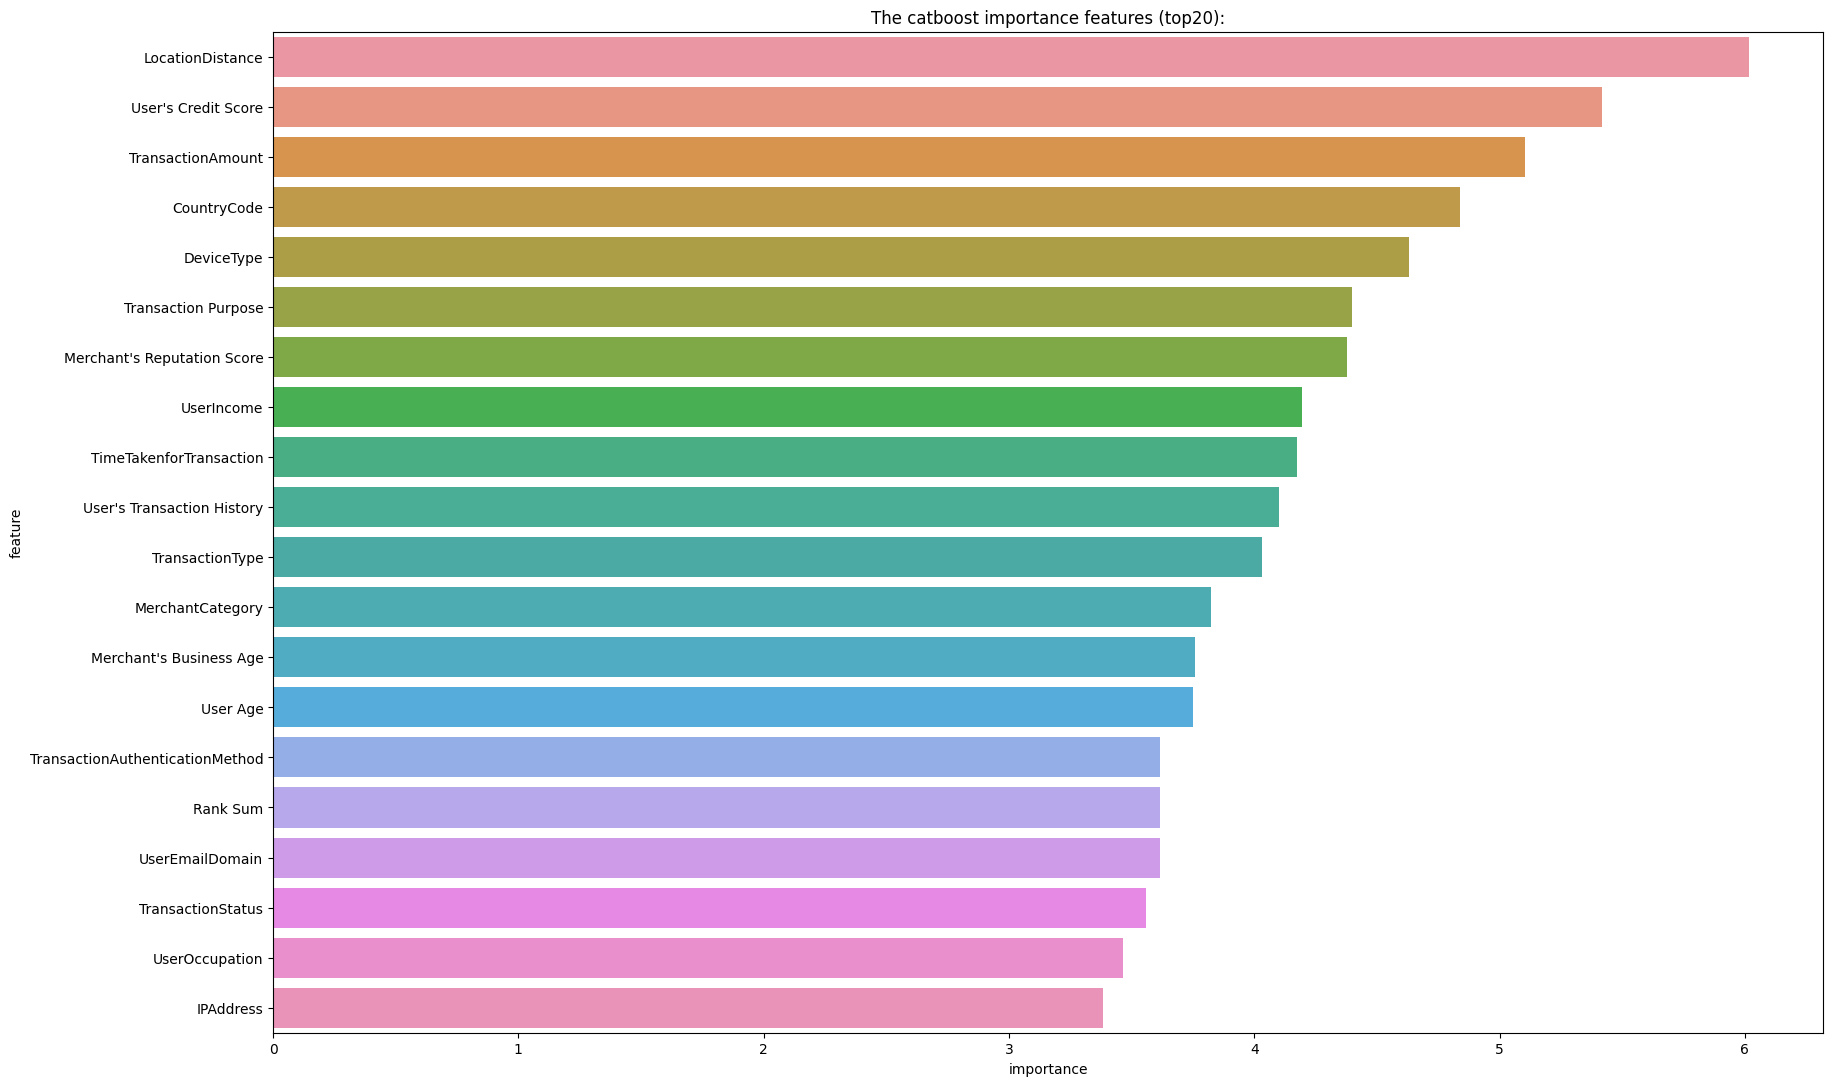

In [52]:
features_catboost = pd.DataFrame(model_catboost.feature_importances_, columns= ['importance'])
features_catboost['feature'] = X_train.columns

plt.figure(figsize= (20,13));
sns.barplot(x="importance", y="feature", data = features_catboost.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('The catboost importance features (top20):');